In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import numpy as np
import lmfit

In [2]:
#caminhos para fazer os DataFrames
df_fermi = pd.read_csv ("CSVs\Dados_Fermi.csv")
df_energia = pd.read_csv("CSVs\Dados_energia.csv")

## Métricas:

In [3]:
# RMSE
from sklearn.metrics import mean_squared_error
def RMSE(x_teste, y_teste, modelo):
    y_verdadeiro = y_teste
    y_previsao = modelo.predict(x_teste)

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    

    return print(f"O RMSE do modelo baseline foi de {RMSE}, porcentagem em relação a média: {abs((RMSE/y_teste.mean()) * 100)}.")

## Para a energia de fermi

In [4]:
from sklearn.model_selection import train_test_split

#escolhe o tamanho do nosso teste
TAMANHO_TESTE = 0.1
# fixa quais dados que vão ser selecionados para teste e treino
SEMENTE_ALEATORIA = 24569
DATASET_NAME = "df_fermi"
# faz uma lista de features que queremos usar, no caso são todas
FEATURES = list(df_fermi.keys())
# tira o nosso target entre as features
FEATURES.remove("Fermi_energy")
FEATURES.remove("Unnamed: 0")
#o que queremos achar
TARGET = ["Fermi_energy"]


indices = df_fermi.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_fe = df_fermi.loc[indices_treino]
df_teste_fe = df_fermi.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
x_treino_fe = df_treino_fe.reindex(FEATURES, axis=1).values
y_treino_fe = df_treino_fe.reindex(TARGET, axis=1).values
x_teste_fe = df_teste_fe.reindex(FEATURES, axis=1).values
y_teste_fe = df_teste_fe.reindex(TARGET, axis=1).values


### Baseline média

In [5]:
from sklearn.dummy import DummyRegressor

# cria o modelo
modelo_baseline_fe = DummyRegressor()

# treina o modelo
modelo_baseline_fe.fit(x_treino_fe, y_treino_fe)

# realiza uma previsão usando o modelo treinado
previsao_fe = modelo_baseline_fe.predict(x_teste_fe)

print(previsao_fe)

[-4.95704166 -4.95704166 -4.95704166 ... -4.95704166 -4.95704166
 -4.95704166]


In [6]:
# testando a qualidade do nosso modelo:
RMSE(x_teste_fe, y_teste_fe, modelo_baseline_fe )

O RMSE do modelo baseline foi de 0.30151342169015477, porcentagem em relação a média: 6.078721445684178.


## Agora para energia por átomo

In [7]:
#escolhe o tamanho do nosso teste
tamanho_teste = 0.1
# fixa quais dados que vão ser selecionados para teste e treino
semente_aleatoria = 24569
# faz uma lista de features que queremos usar, no caso são todas
features = list(df_energia.keys())
# tira o nosso target entre as features
features.remove("energy_per_atom")
features.remove("Unnamed: 0")
#o que queremos achar
target = ["energy_per_atom"]


indices = df_energia.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=tamanho_teste, random_state= semente_aleatoria
)

df_treino_en = df_energia.loc[indices_treino]
df_teste_en = df_energia.loc[indices_teste]

# observe que usamos o .values aqui pois queremos apenas os valores
x_treino_en = df_treino_en.reindex(features, axis=1).values
y_treino_en = df_treino_en.reindex(target, axis=1).values
x_teste_en = df_teste_en.reindex(features, axis=1).values
y_teste_en = df_teste_en.reindex(target, axis=1).values

### Baseline média

In [8]:
# cria o modelo
modelo_baseline_en = DummyRegressor()

# treina o modelo
modelo_baseline_en.fit(x_treino_en, y_treino_en)

# realiza uma previsão usando o modelo treinado
previsao_en = modelo_baseline_en.predict(x_teste_en)

print(previsao_en)

[-47.41313446 -47.41313446 -47.41313446 ... -47.41313446 -47.41313446
 -47.41313446]


In [9]:
# testando a qualidade do nosso modelo:
RMSE(x_teste_en, y_teste_en, modelo_baseline_en )

O RMSE do modelo baseline foi de 2.353630547946566, porcentagem em relação a média: 4.965411373597822.


# Modelo KNN

In [10]:
#Cria o algoritmo de identificação de vizinhos mais próximos;

def identificacaoknn(x_treino, y_treino, x_teste, y_teste, target_name): #Definir uma função para calcular os vizinhos, já que temos dois targets numéricos
    ""
    media_teste = y_teste.mean()
    media_treino = y_treino.mean()

    from sklearn.metrics import mean_squared_error 
    from sklearn.neighbors import KNeighborsRegressor
    
    #variando o hiperparâmetro k, que corresponde ao numero de vizinhos
    numero_vizinhos = range(1, 101)
    rmse = []
    for n in numero_vizinhos: #for para testar
        # função para criar o modelo com a qtde n de vizinhos
        modelo_knn = KNeighborsRegressor(n_neighbors=n)

        # treina o modelo
        modelo_knn.fit(x_treino, y_treino)

        # realiza uma previsão usando o modelo treinado
        previsao = modelo_knn.predict(x_teste)
        #print(previsao)

        y_verdadeiro = y_teste
        y_previsao = modelo_knn.predict(x_teste)
        RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
        rmse.append(RMSE)
        
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(numero_vizinhos, rmse, c = 'r')
    ax1.set_xlabel('Número de vizinhos')
    ax1.set_ylabel('RMSE (eV)')
        
    def reta(x, a, b):
        return a*x + b

    reta_model=lmfit.Model(reta)

        #se der errado tentar mexer nesses valores do chute inicial:
        
    reta_model.set_param_hint('a',value=1,min= -1000000,max=3000000,vary=True) 
    reta_model.set_param_hint('b',value=1,min=-200000,max=2000000,vary=True) 
    param = reta_model.make_params()

    results = reta_model.fit(y_previsao, x = y_verdadeiro, params = param)
    #print(results.fit_report())
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange')
    ax2.plot(y_verdadeiro,results.best_fit,label="Regressão Linear", c = 'r') ; ax2.legend(fontsize='small')
    
    if target_name ==  'Energia de Fermi':
        ax2.set_title('Previsão k-NN para Energia de Fermi')
    if target_name == 'Energia por Átomo':
        ax2.set_title('Previsão k-NN para Energia por Átomo')

    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')
    
    
    m = min(rmse)
    km = numero_vizinhos[rmse.index(m)]
    print(f"O RMSE do modelo k-NN usando k={km} foi de {m} eV. O erro percentual é, {abs((m/media_teste) * 100)} %")

O RMSE do modelo k-NN usando k=25 foi de 0.08594171465090313 eV. O erro percentual é, 1.7326450709851542 %


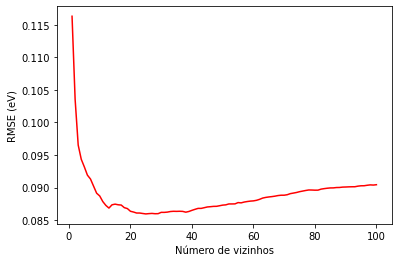

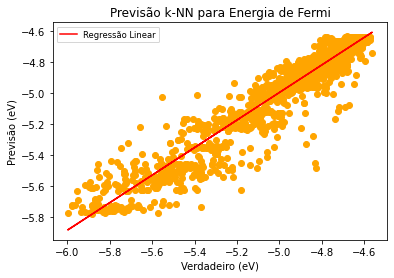

In [11]:
identificacaoknn(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe, 'Energia de Fermi')

O RMSE do modelo k-NN usando k=3 foi de 0.8057468565124171 eV. O erro percentual é, 1.6998694247310895 %


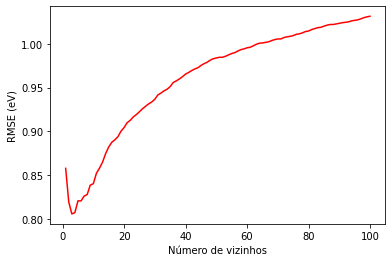

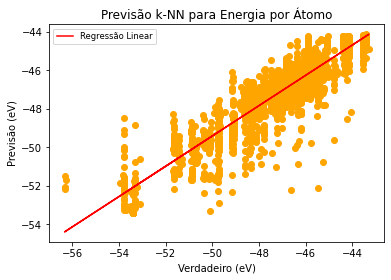

In [21]:
identificacaoknn(x_treino_en, y_treino_en, x_teste_en, y_teste_en, 'Energia por Átomo')

## Para a energia de Fermi, o modelo de k-NN resultou em um RMSE cerca de 3.5 vezes menor que o baseline, já para a energia total por átomo resultou em um RMSE cerca de 3 vezes menor que o baseline.

# Modelo Linear (não normalizado)

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:

def modelo_linear(x_treino, y_treino, x_teste, y_teste, target_name):
    # cria o modelo
    modelo_linear = LinearRegression()

    # treina o modelo
    modelo_linear.fit(x_treino, y_treino)

    # realiza uma previsão usando o modelo treinado
    previsao = modelo_linear.predict(x_teste)
    #print(previsao)

    y_verdadeiro = y_teste
    y_previsao = modelo_linear.predict(x_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    
    def reta(x, a, b):
        return a*x + b

    reta_model=lmfit.Model(reta)

        #se der errado tentar mexer nesses valores do chute inicial:
        
    reta_model.set_param_hint('a',value=1,min= -1000000,max=3000000,vary=True) 
    reta_model.set_param_hint('b',value=1,min=-200000,max=2000000,vary=True) 
    param = reta_model.make_params()

    results = reta_model.fit(y_previsao, x = y_verdadeiro, params = param)
    #print(results.fit_report())
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange')
    ax2.plot(y_verdadeiro,results.best_fit,label="Regressão Linear", c = 'r') ; ax2.legend(fontsize='small')
    if target_name ==  'Energia de Fermi':
        ax2.set_title('Previsão linear para Energia de Fermi')
    if target_name == 'Energia por Átomo':
        ax2.set_title('Previsão linear para Energia por Átomo')
    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')
    
    print(f"O modelo linear produziu um RMSE de {RMSE} eV")

### Energia de Fermi:

O modelo linear produziu um RMSE de 0.09438584636064312 eV


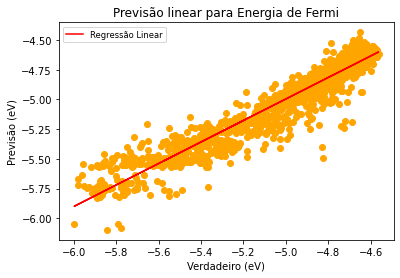

In [24]:
modelo_linear(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe, 'Energia de Fermi')

Para a energia de Fermi o modelo linear deu um resultado melhor que o baseline, mas pior que o kNN

### Energia por Átomo

O modelo linear produziu um RMSE de 0.4226204459755578 eV


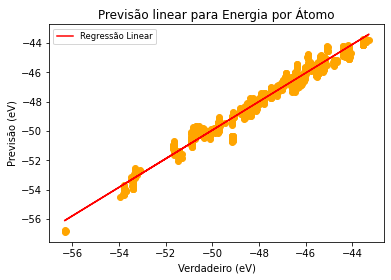

In [25]:
modelo_linear(x_treino_en, y_treino_en, x_teste_en, y_teste_en, 'Energia por Átomo')

Para a energia por átomo o modelo linear deu resultado melhor que o baseline e que o kNN

# Modelo Linear (normalizado)

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
def modelo_linear_normalizado(x_treino, y_treino, x_teste, y_teste, target_name):

    normalizador_x = MinMaxScaler()
    normalizador_y = MinMaxScaler()

    normalizador_x.fit(x_treino)
    normalizador_y.fit(y_treino)
    # cria o modelo
    modelo_linear = LinearRegression()

    # treina o modelo
    modelo_linear.fit(
        normalizador_x.transform(x_treino),
        normalizador_y.transform(y_treino),
    )

    # realiza uma previsão usando o modelo treinado
    previsao = modelo_linear.predict(normalizador_x.transform(x_treino))
    previsao = normalizador_y.inverse_transform(previsao)
    #print(previsao)
    y_verdadeiro = y_teste
    y_previsao = modelo_linear.predict(normalizador_x.transform(x_teste))
    y_previsao = normalizador_y.inverse_transform(y_previsao)

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    def reta(x, a, b):
        return a*x + b

    reta_model=lmfit.Model(reta)

        #se der errado tentar mexer nesses valores do chute inicial:
        
    reta_model.set_param_hint('a',value=1,min= -1000000,max=3000000,vary=True) 
    reta_model.set_param_hint('b',value=1,min=-200000,max=2000000,vary=True) 
    param = reta_model.make_params()

    results = reta_model.fit(y_previsao, x = y_verdadeiro, params = param)
    #print(results.fit_report())
    
    fig, ax2 = plt.subplots(1,1)
    ax2.scatter(y_verdadeiro, y_previsao, c = 'orange')
    ax2.plot(y_verdadeiro,results.best_fit,label="Regressão Linear", c = 'r') ; ax2.legend(fontsize='small')
    if target_name ==  'Energia de Fermi':
        ax2.set_title('Previsão linear (normalizado) para Energia de Fermi')
    if target_name == 'Energia por Átomo':
        ax2.set_title('Previsão linear (normalizado) para Energia por Átomo')
    ax2.set_xlabel('Verdadeiro (eV)')
    ax2.set_ylabel('Previsão (eV)')

    print(f"O RMSE do modelo linear normalizado foi de {RMSE} eV.")

### Energia de Fermi

O RMSE do modelo linear normalizado foi de 0.09438584636064316 eV.


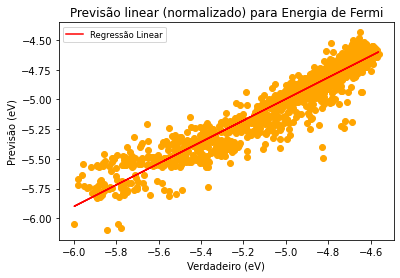

In [28]:
modelo_linear_normalizado(x_treino_fe, y_treino_fe, x_teste_fe, y_teste_fe,'Energia de Fermi' )

### Energia por Átomo

O RMSE do modelo linear normalizado foi de 0.42262044597555626 eV.


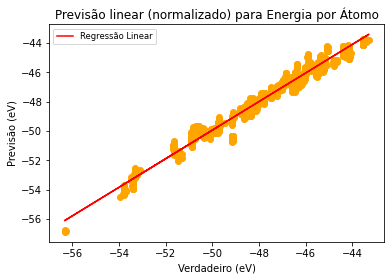

In [29]:
modelo_linear_normalizado(x_treino_en, y_treino_en, x_teste_en, y_teste_en,'Energia por Átomo')

Nota-se que a normalização não alterou a qualidade do modelo.